<a href="https://colab.research.google.com/github/Gheras13/Homework/blob/main/Homewrok_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MACHINE LEARNING HOMEWORK 1

#DIRECT KINEMATICS OF ROBOT MANIPLUATOR

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Generate Data

In [3]:


# Percorso del file CSV
file_path = '/content/drive/My Drive/File_csv/Copia di r2_20_100k.csv'

# Carica il dataset
df = pd.read_csv(file_path, sep=';', header=0)

# Rimuovi eventuali spazi dai nomi delle colonne
df.columns = df.columns.str.strip()

# Stampa i nomi delle colonne disponibili
print("Colonne disponibili nel dataset:", df.columns.tolist())

# Estrai le feature (j0, j1) e i target (ee_x, ee_y)
X = df[['j0', 'j1']].values  # Angoli articolari
Y = df[['ee_x', 'ee_y']].values  # Posizioni finali (end-effector)

# Verifica i dati caricati
print("Esempio di X (features):", X[:5])  # Prime 5 righe delle feature
print("Esempio di Y (target):", Y[:5])  # Prime 5 righe del target


Colonne disponibili nel dataset: ['j0', 'j1', 'cos(j0)', 'cos(j1)', 'sin(j0)', 'sin(j1)', 'ee_x', 'ee_y', 'ee_qw', 'ee_qz']
Esempio di X (features): [[-0.044 -0.008]
 [-0.062 -0.011]
 [-0.126 -0.015]
 [-0.226 -0.051]
 [-0.364 -0.082]]
Esempio di Y (target): [[ 0.21  -0.01 ]
 [ 0.21  -0.014]
 [ 0.208 -0.028]
 [ 0.203 -0.053]
 [ 0.193 -0.083]]


In [4]:
# Dividi i dati in training e testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# (Opzionale) Standardizza gli input per migliorare la stabilità numerica
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

Y_train = scaler_Y.fit_transform(Y_train)
Y_test = scaler_Y.transform(Y_test)

In [5]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2)
    ])
    return model


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0781 - mae: 0.1305 - val_loss: 0.0057 - val_mae: 0.0615
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0025 - mae: 0.0365 - val_loss: 0.0020 - val_mae: 0.0367
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0020 - mae: 0.0325 - val_loss: 8.6025e-04 - val_mae: 0.0227
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0018 - mae: 0.0291 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011 - mae: 0.0246 - val_loss: 0.0046 - val_mae: 0.0527
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0019 - mae: 0.0319 - val_loss: 8.1911e-04 - val_mae: 0.0227
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0013 - mae: 0.0265 - val_loss: 0.0013 - val_mae: 0.0277
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0010 - mae: 0.0236 - val_loss: 0.0010 - val_mae: 0.0247
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3

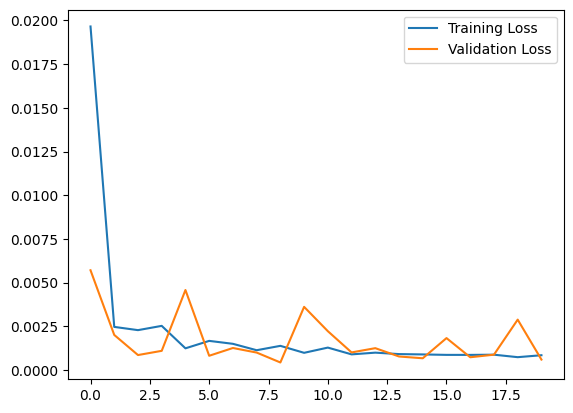

In [6]:
# Costruzione e compilazione del modello
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

# Addestramento
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Valutazione sul test set
loss, mae = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Traccia l'andamento della perdita
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [7]:
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)  # Forward pass
    return tape.jacobian(y, x)

def FK(model, theta):
    # Reshape to batch size 1
    t = tf.reshape(theta, shape=(1, 2))
    out = model(t)
    # Reshape to 1d vector
    out = tf.reshape(out, shape=(2,))
    return out


In [8]:
def analytical_J(theta, L1=1.0, L2=1.0):
    j0, j1 = theta
    J = np.array([
        [-L1 * np.sin(j0) - L2 * np.sin(j0 + j1), -L2 * np.sin(j0 + j1)],
        [L1 * np.cos(j0) + L2 * np.cos(j0 + j1),  L2 * np.cos(j0 + j1)]
    ])
    return J

# Esempio di confronto
theta_sample = X_test[0]  # Primo esempio di test
jacobian_learned = FK_Jacobian(model, tf.convert_to_tensor([theta_sample], dtype=tf.float32))
jacobian_analytical = analytical_J(theta_sample)

print("Jacobiana appresa:\n", jacobian_learned.numpy())
print("Jacobiana analitica:\n", jacobian_analytical)


Jacobiana appresa:
 [[[-2.2714272 -2.1082573]]

 [[-0.9171089  1.2796636]]]
Jacobiana analitica:
 [[-1.36859533 -0.37666199]
 [ 1.05311138  0.92635077]]


In [9]:
from itertools import product

hidden_layers = [64, 128]
learning_rates = [0.01, 0.001]

results = []

for hl, lr in product(hidden_layers, learning_rates):
    print(f"Testing model with {hl} hidden neurons and {lr} learning rate")
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hl, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(hl, activation='relu'),
        tf.keras.layers.Dense(2)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
    loss, mae = model.evaluate(X_test, Y_test, verbose=0)
    results.append((hl, lr, loss, mae))

# Riporta i risultati migliori
for res in results:
    print(f"Hidden Neurons: {res[0]}, Learning Rate: {res[1]}, Loss: {res[2]}, MAE: {res[3]}")


Testing model with 64 hidden neurons and 0.01 learning rate
Testing model with 64 hidden neurons and 0.001 learning rate
Testing model with 128 hidden neurons and 0.01 learning rate
Testing model with 128 hidden neurons and 0.001 learning rate
Hidden Neurons: 64, Learning Rate: 0.01, Loss: 0.0020351335406303406, MAE: 0.03557761013507843
Hidden Neurons: 64, Learning Rate: 0.001, Loss: 0.00026304993662051857, MAE: 0.012791687622666359
Hidden Neurons: 128, Learning Rate: 0.01, Loss: 0.0011639671865850687, MAE: 0.02717823162674904
Hidden Neurons: 128, Learning Rate: 0.001, Loss: 0.0002479330578353256, MAE: 0.011912195943295956
